<a href="https://colab.research.google.com/github/AACRobinson/IMLO-Assessment/blob/main/IMLO_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initialisation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io
import sklearn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Resize, InterpolationMode
from torch import nn
from torch.utils.data import DataLoader


device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print("Using", device, "device\n")


trainFlowers = datasets.Flowers102 (
    root="data",
    split="train",
    download=True,
    transform=Compose([ToTensor(), Resize((1500, 1500))]) #Need to convert all images to the same tensor dimensions - largest images have width/height of ~1500
)

validateFlowers = datasets.Flowers102 (
    root="data",
    split="val",
    download=True,
    transform=Compose([ToTensor(), Resize((1500, 1500))])
)

testFlowers = datasets.Flowers102 (
    root="data",
    split="test",
    download=True,
    transform=Compose([ToTensor(), Resize((1500, 1500))])
)

trainDataLoader = DataLoader(trainFlowers, batch_size=64, shuffle=True)
testDataLoader = DataLoader(testFlowers, batch_size=64, shuffle=True)

Using cuda device



# **Visualisation**

Feature batch shape:  torch.Size([64, 3, 1500, 1500])
Labels batch shape:  torch.Size([64])


<ipython-input-3-4eb48f35644d>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  image = train_features[0].squeeze().T #Need to transpose the tensor for the dimensions to be correct (3, 1500, 1500) -> (1500, 1500, 3)


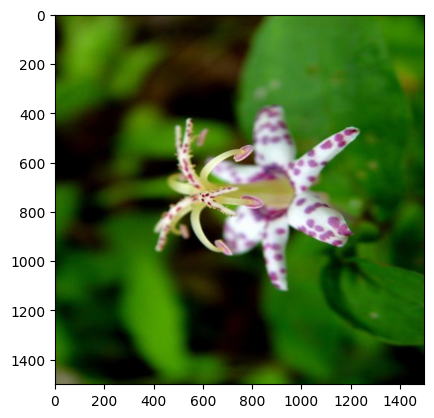

Label:  78


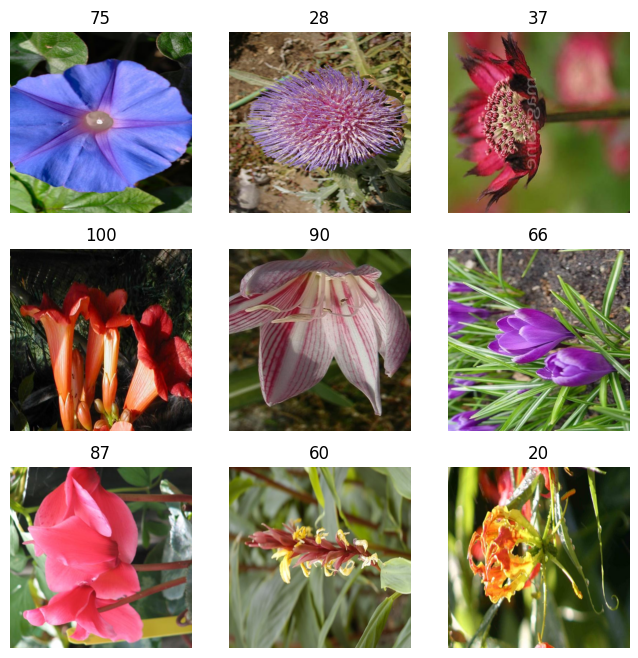

In [3]:
train_features, train_labels = next(iter(trainDataLoader))
print("Feature batch shape: ", train_features.size())
print("Labels batch shape: ", train_labels.size())
image = train_features[0].squeeze().T #Need to transpose the tensor for the dimensions to be correct (3, 1500, 1500) -> (1500, 1500, 3)
label = train_labels[0].item()
plt.imshow(image)
plt.show()
print("Label: ", label)


figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1) :
  sample_index = torch.randint(len(trainFlowers), size=(1,)).item()
  image, label = trainFlowers[sample_index]
  figure.add_subplot(rows, cols, i)
  plt.title(trainFlowers[sample_index][1])
  plt.axis("off")
  plt.imshow(image.squeeze().T)
plt.show()

# **Building the NN**

In [ ]:
class flowerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1500*1500, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 102),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

flowerNNModel = flowerNN().to(device)
modelLR = 0.0001
modelBatchSize = 64
epochs = 64
lossFunct = nn.CrossEntropyLoss()
modelOptimiser = torch.optim.SGD(flowerNNModel.parameters(), modelLR)

def trainer(dataloader, nnModel, lossFunct, modelOptimiser) :
  nnModel.train()
  for modelBatch, (X, y) in enumerate(dataloader) :
    prediction = nnModel(X)
    loss = lossFunct(prediction, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if batch % 100 == 0 :
      loss, current = loss.item(), modelBatch * modelBatchSize + len(X)
      print("Loss: ", round(loss, 2), "(", current, "/", len(dataloader.dataset), ")")

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainer(trainDataLoader, flowerNNModel, lossFunct, modelOptimizer)
print("Done!\n\n")